In [1]:
# this notebook will synthesize all of the pieces so far of the stream power - abrasion model
# it will include:
# a characteristic alluvial thickness
# an exponential factor for bed cover
# a way to track the percentages of lithologies in the alluvial layer
# a way to track the thickness of the alluvial layer

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1
x = np.arange(0, 100, dx)

# percentages in basin
amt_ig = 0.64
amt_mtm = 0.24
amt_sed = 0.0
amt_qtz = 0.12

# SET CONSTANTS
# characteristic alluvial thickness
Hstar = 2

# 1 - porosity
porosity = 0.55

# water discharge
q = x

# lumped factor, encapsulates roughness, grain size, etc. I have no idea what it's value should be...
c = 1

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = 0.004
beta_mtm = 0.1
beta_sed = 0.098
beta_qtz = 0.0015

# SET UP TIME
num_steps = 1000
dt = (0.2 * dx * dx)/c

In [4]:
# write a function that has everything
def Bedrock_Alluvium(x,
                     q, 
                     num_steps,
                     amt_ig,
                     amt_mtm,
                     amt_sed,
                     amt_qtz,
                     beta_ig,
                     beta_mtm,
                     beta_sed,
                     beta_qtz,
                     k = 0.001,
                     c = 1,
                     S = 0.001, 
                     porosity = 0.55,
                     Hstar = 2):
    
    """ The arguments to this function require the following data types:
        
        x : array
        q : array of length x
        num_steps : int
        amt_ig : float, < 1
        amt_mtm : float, < 1
        amt_sed : float, < 1
        amt_qtz : float, < 1
        (amt_ig + amt_mtm + amt_sed + amt_qtz should always = 1)
        beta_ig : float
        beta_mtm : float
        beta_sed : float
        beta_qtz : float
        k : float
        c : float or int
        S : float or int
        porosity : float, < 1
        Hstar : float or int """
    
    # create array to hold elevations
    H_ig = np.zeros(len(x))
    H_mtm = np.zeros(len(x))
    H_sed = np.zeros(len(x))
    H_qtz = np.zeros(len(x))
    H = H_ig + H_mtm + H_sed + H_qtz
    H[-1] = 0
    etab = np.zeros(len(x))
    eta = etab + H
    ero = np.zeros(len(x))
    
    # create arrays to hold sediment fluxes
    qs = np.zeros(len(x))
    qs_ig = np.zeros(len(x))
    qs_mtm = np.zeros(len(x))
    qs_sed = np.zeros(len(x))
    qs_qtz = np.zeros(len(x))
    
    # create arrays to hold percentages of different lithologies
    theta = 1
    theta_ig = np.zeros(len(x))
    theta_mtm = np.zeros(len(x))
    theta_sed = np.zeros(len(x))
    theta_qtz = np.zeros(len(x))
    theta_sed[:] = theta
    
    for i in range(num_steps):
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
    
        # calculate flux of each lithology
        qs_ig[1:] = qs[1:] * (theta_ig[:-1])
        qs_mtm[1:] = qs[1:] * (theta_mtm[:-1])
        qs_sed[1:] = qs[1:] * (theta_sed[:-1])
        qs_qtz[1:] = qs[1:] * (theta_qtz[:-1])
    
        # set constant, mixed feed of grains
        qs_ig[0] = amt_ig
        qs_mtm[0] = amt_mtm
        qs_sed[0] = amt_sed
        qs_qtz[0] = amt_qtz
    
        # update percentage of each grain type
        theta_ig[:-1] += ((-1/(porosity * Hstar)) * ((np.diff(qs_ig)/dx) + (qs_ig[1:] * beta_ig))) * dt
        theta_mtm[:-1] += ((-1/(porosity * Hstar)) * ((np.diff(qs_mtm)/dx) + (qs_mtm[1:] * beta_mtm))) * dt
        theta_sed[:-1] += ((-1/(porosity * Hstar)) * ((np.diff(qs_sed)/dx) + (qs_sed[1:] * beta_sed))) * dt
        theta_qtz[:-1] += ((-1/(porosity * Hstar)) * ((np.diff(qs_qtz)/dx) + (qs_qtz[1:] * beta_qtz))) * dt
    
        # conserve mass
        theta_total = theta_ig + theta_mtm + theta_sed + theta_qtz
        dtheta = theta - theta_total
        theta_ig += dtheta * theta_ig
        theta_mtm += dtheta * theta_mtm
        theta_sed += dtheta * theta_sed
        theta_qtz += dtheta * theta_qtz
        
        # calc bedrock erosion from stream power (plucking)
        ero_sp = efac[:-1] * (k * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        # here our bedrock is entirely sedimentary, 
        # so the amount of erosion from abrasion depends on the sedimentary abrasion coefficient
        # and the total sediment flux
        ero_ab = efac[:-1] * (beta_sed * qs[1:])
        
        # calc bedrock erosion rate from stream power and abrasion
        ero[:-1] = ero_sp + ero_ab
        
        # calc change in bedrock elev
        etab[:-1] -= ero[:-1] * dt
        
        # calc grain attrition
        ig_atr = beta_ig * qs_ig[1:]
        mtm_atr = beta_mtm * qs_mtm[1:]
        sed_atr = beta_sed * qs_sed[1:]
        qtz_atr = beta_qtz * qs_qtz[1:]
        
        # calc change in alluvial thickness
        # taking out theta because it's already accounted for
        
        # H_ig[:-1] += -((1 / theta_ig[:-1] * porosity) * ((np.diff(qs_ig)/dx) + (qs_ig[1:] * beta_sed) - ero_sp + (qs_ig[1:] * beta_ig)))
        H_ig[:-1] += -((1 / porosity) * ((np.diff(qs_ig)/dx) + (qs_ig[1:] * beta_sed) - ero_sp + ig_atr))
        
        # H_mtm[:-1] += -((1 / theta_mtm[:-1] * porosity) * ((np.diff(qs_mtm)/dx) + (qs_mtm[1:] * beta_sed) - ero_sp + (qs_mtm[1:] * beta_mtm)))
        H_mtm[:-1] += -((1 / porosity) * ((np.diff(qs_mtm)/dx) + (qs_mtm[1:] * beta_sed) - ero_sp + mtm_atr))
        
        # H_sed[:-1] += -((1 / theta_sed[:-1] * porosity) * ((np.diff(qs_sed)/dx) + (2 * qs_sed[1:] * beta_sed) - ero_sp))
        H_sed[:-1] += -((1 / porosity) * ((np.diff(qs_sed)/dx) + (2 * sed_atr) - ero_sp))
        
        # H_qtz[:-1] += -((1 / theta_qtz[:-1] * porosity) * ((np.diff(qs_qtz)/dx) + (qs_qtz[1:] * beta_sed) - ero_sp + (qs_qtz[1:] * beta_qtz)))
        H_qtz[:-1] += -((1 / porosity) * ((np.diff(qs_qtz)/dx) + (qs_qtz[1:] * beta_sed) - ero_sp + qtz_atr))
        
        H[:-1] += H_ig[:-1] + H_mtm[:-1] + H_sed[:-1] + H_qtz[:-1]
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        return eta, etab, ero_sp, ero_ab, H_ig, H_mtm, H_sed, H_qtz, H, theta_ig, theta_mtm, theta_sed, theta_qtz, theta

In [5]:
eta, etab, ero_sp, ero_ab, H_ig, H_mtm, H_sed, H_qtz, H, theta_ig, theta_mtm, theta_sed, theta_qtz, theta = Bedrock_Alluvium(x,
                                                                                                                             q, 
                                                                                                                             num_steps,
                                                                                                                             amt_ig,
                                                                                                                             amt_mtm,
                                                                                                                             amt_sed,
                                                                                                                             amt_qtz,
                                                                                                                             beta_ig,
                                                                                                                             beta_mtm,
                                                                                                                             beta_sed,
                                                                                                                             beta_qtz)

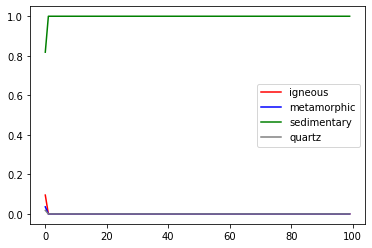

In [6]:
plt.plot(x, theta_ig/theta, color = 'r', label = 'igneous')
plt.plot(x, theta_mtm/theta, color = 'b', label = 'metamorphic')
plt.plot(x, theta_sed/theta, color = 'g', label = 'sedimentary')
plt.plot(x, theta_qtz/theta, color = 'gray', label = 'quartz')
plt.legend()
plt.show()

In [8]:
theta_ig

array([0.09520661, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     